In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn

def log_sum_exp(tensor, dim=-1, sum_op=torch.sum):
    """
    Uses the LogSumExp (LSE) as an approximation for the sum in a log-domain.
    :param tensor: Tensor to compute LSE over
    :param dim: dimension to perform operation over
    :param sum_op: reductive operation to be applied, e.g. torch.sum or torch.mean
    :return: LSE
    """
    max, _ = torch.max(tensor, dim=dim, keepdim=True)
    return torch.log(sum_op(torch.exp(tensor - max), dim=dim, keepdim=True) + 1e-8) + max

### Problem

We consider a egression problem with scalar features $x$, scalar targets $t$ and known variance $\sigma^2$ We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic 1-dimensional basis function $\phi$, the likelihood is expressed as:

\begin{align}
p(t | a, b, x, \sigma) & = \mathcal{N}(a \phi(x) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(a) = \mathcal{N}(0,1) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

It is then possible to compute the posterior of parameters analytically, given $(\mathbf{x}, \mathbf{t})$ the entire dataset:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}, \sigma^2) = \frac{p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2) p(a,b)}{p(\mathbf{t}, \mathbf{x})}
\end{align}

$p(\mathbf{t})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Issue with $p(\mathbf{t}, \mathbf{x}, \theta)$

We now consider a learnt basis function $f$ with parameters $\theta$, $f$ can be arbitrarly complex and be implemented using any parametric model. We, however, do not treat $\theta$ in a bayesian manner as the problem would quickly become intractable. The likelihood is now:

\begin{align}
p(t | a, b, x, \sigma, \theta) & = \mathcal{N}(a f_{\theta}(x) + b, \sigma^2) 
\end{align}


and the posterior distribution is:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}, \sigma^2,  \theta) = \frac{p(\mathbf{t} | a, b, \sigma^2, \theta) p(a,b)}{p(\mathbf{t}, \mathbf{x}, \theta)}
\end{align}

However, $p(\mathbf{t}, \mathbf{x}, \theta)$ is intractable and not constant. Hence, we cannot using MCMC. **<- I am still uncertain about that: isn't $p(\theta)$ independent of $p(x,t)$ ?**

#### Bayes by Backprop

We propose to optimize $\theta$ using maximum likelihood and $a, b$ using Variational Inference, which allows us deriving a lower bound of the marginal log likelihood (with regards to $a,b$) that we can optimize end-to-end. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x}, \sigma^2, \theta) & = \log \int_{a,b} \log p(\mathbf{t}, a, b, | \mathbf{x}, \sigma^2, \theta) dadb \\
& = \log \int_{a,b} \log p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta)p(a,b) dadb \\
& = \log \int_{a,b} q(a,b) p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} dadb \\
& \geq \mathbb{E}_{q(a,b)} \left[ \log  p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} \right] \\
& = \mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] - \mathrm{KL}(q(a,b) \ ||\ p(a,b)) \\
= \mathcal{L_(t, x)}
\end{align}

with

\begin{split}
\mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] =  \mathbb{E}_q \left[ \sum_{x \in \mathbf{x}} \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t - a f_{\theta}(x) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(a,b) \ ||\ p(a,b)) = -\frac{1}{2} \sum_{i\in\{a,b\}} \left(1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2\right)
\end{split}

#### Importance weighted bound

We have 

\begin{align}
\mathcal{L_(t, x)} & =  \mathbb{E}_{q(a,b)} \left[ \log \frac{ p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) p(a,b)}{q(a,b)} \right] 
\end{align}

We can compute the Importance Weighted bound by sampling several time from $q$:

\begin{align}
\mathcal{L_k(t, x)} & =  \mathbb{E}_{q(a,b)} \left[ \log \frac{1}{k} \sum_{i=1}^k \frac{ p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) p(a,b)}{q(a,b)} \right] \\
& = \log \frac{1}{k} \sum_{i=1}^k e^{\mathcal{L}(t,x)}
\end{align}


#### Toy Dataset 1

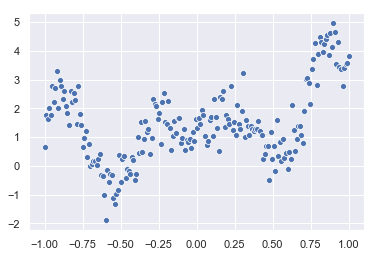

In [2]:
N = 200
a = 0.5
b = 0.2
sigma = 0.5  # observation noise
x = np.linspace(-1, 1, N).reshape(-1, 1)
fx = x * 5 * np.sin(9 * x) + 2*(x + 1)
t = a*fx + b + sigma*np.random.randn(*x.shape)  # observations
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 1))
        
    def forward(self, x):
        return self.layers(x)
    
    
class StochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        """KL from standard normal. Independent variables, shape is irrelevant, KL is summed over all dimensions."""
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum()
    
    


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise std $\sigma$.

In [4]:
features = FeaturesExtractor()
stochastic = StochasticLayer()
l_rate = 0.01
epochs = 3000
n_samples = 10  # MC samples per example
mu_ab = nn.Parameter(torch.tensor([[0., 0.]]))  # for a and b
logvar_ab = nn.Parameter(torch.tensor([[0., 0.]]))  # for a and b
logvar = nn.Parameter(torch.tensor(0.))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, logvar], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    elbo = torch.zeros((n_samples), device=x.device)
    for i in range(n_samples):
        ## Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, logvar_ab)
        a, b = ab_sample.chunk(2, dim=1)
        y = a * h + b  # stochasticity here only comes from a and b
        expected_mse_i = (t - a * h - b)**2
    
        ## Reconstruction loss, estimated by MC
        recons_i = (0.5/logvar.exp() * expected_mse_i + 0.5*logvar)  # recons per example
    
        ## KL loss, both analytic and by MC
        #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
        kl = stochastic.get_kl(mu_ab, logvar_ab)
    
        elbo[i] = - recons_i.sum() - kl
        
    # IW averaging
    elbo = log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == epochs-1:
        print(f'epoch {epoch} : ELBO {elbo.data.item():.3f}')

epoch 0 : ELBO -189.393
epoch 250 : ELBO -82.408
epoch 500 : ELBO -42.959
epoch 750 : ELBO -42.100
epoch 1000 : ELBO -28.370
epoch 1250 : ELBO -30.683
epoch 1500 : ELBO -22.298
epoch 1750 : ELBO -20.619
epoch 2000 : ELBO -15.400
epoch 2250 : ELBO -11.961
epoch 2500 : ELBO -9.949
epoch 2750 : ELBO -8.323
epoch 2999 : ELBO -10.400


### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

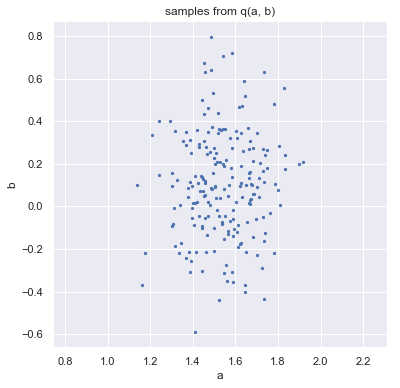

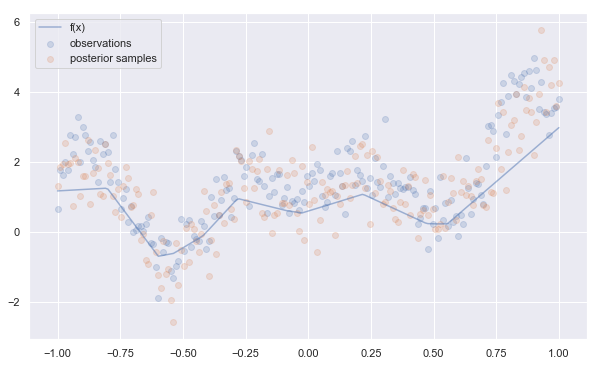

In [5]:
# Get parameters of q(a) and q(b)
mu_a = mu_ab[0, 0].detach().numpy()
mu_b = mu_ab[0, 1].detach().numpy()
std_a = (logvar_ab[0, 0]/2).exp().detach().numpy()
std_b = (logvar_ab[0, 1]/2).exp().detach().numpy()

# Sample a, b ~ q(a, b) and show
n_samples = t.shape[0]
a = np.random.randn(n_samples) * std_a + mu_a
b = np.random.randn(n_samples) * std_b + mu_b
plt.figure(figsize=(6, 6))
plt.pcolor
plt.scatter(a, b, s=5)
plt.xlabel('a')
plt.ylabel('b')
plt.title('samples from q(a, b)')
plt.gca().set_aspect('equal', 'datalim')  # equal aspect ratio
plt.show()

# For each x_i, use samples a_i, b_i to compute predicted t_i
h = features(x).squeeze().detach().numpy()
post_samples = a * h + b + (logvar/2).exp().detach().numpy() * np.random.randn(*a.shape)
plt.figure(figsize=(10,6))
plt.scatter(x, t, alpha=0.2, label='observations')
plt.scatter(x, post_samples, alpha=0.2, label='posterior samples')
plt.plot(x.numpy(), h, alpha=0.5, label='f(x)')
# plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='95% posterior interval')
# plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()

In [6]:
print('a: N({:.3g}, {:.3g})'.format(mu_ab[0, 0], logvar_ab[0, 0].exp()))
print('b: N({:.3g}, {:.3g})'.format(mu_ab[0, 1], logvar_ab[0, 1].exp()))
print('noise var: {:.3g} (true value {:.3g})'.format(logvar.exp(), sigma**2))

a: N(1.54, 0.0191)
b: N(0.123, 0.0635)
noise var: 0.399 (true value 0.25)


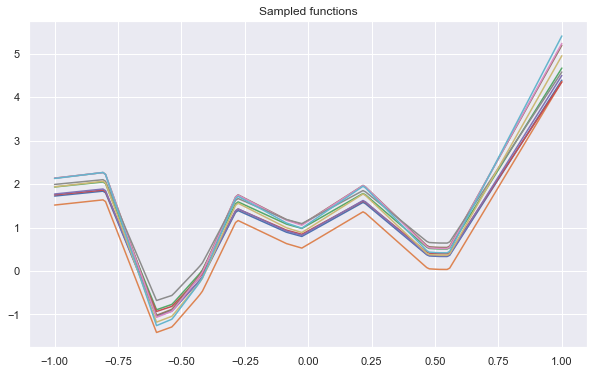

In [7]:
plt.figure(figsize=(10,6))

with torch.no_grad():
    mu_a = mu_ab[0, 0].detach()
    mu_b = mu_ab[0, 1].detach()
    std_a = (logvar_ab[0, 0]/2).exp().detach()
    std_b = (logvar_ab[0, 1]/2).exp().detach()
    
    n_samples = 5
    a = torch.distributions.Normal(mu_a, std_a).sample((10,))
    b = torch.distributions.Normal(mu_b, std_b).sample((10,))
    x = torch.linspace(-1,1, N)
    h =  features(x[:,None]).squeeze().data.numpy()
    for k in range(10):
        plt.plot(x.squeeze().data.numpy(), a[k].item() * h + b[k].item())
    
    
plt.title('Sampled functions')
plt.show()
